# Определение стоимости поддержанных автомобилей для онлайн-сервиса

Заказчик исследования - компания "X". Компания ведёт сервис по продаже автомобилей с пробегом и в данный момент разрабатывает приложение для привлечения клиентов, в котором можно быстро узнать рыночную стоимость своего автомобиля. Необходимо построить модель для определения этой стоимости. Входные данные - исторические данные объявлений автомобилей (технические характеристики, комплектации, цены). Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Результаты исследования будут использованы заказчиком в коммерческих целях.

**Цель исследования**: подготовить прототип модели машинного обучения по определению стоимости автомобиля с пробегом по его характеристикам.

Ход исследования:

Входные данные от компании - исторические сведения об автомобилях с пробегом. Перед анализом данные необходимо загрузить и подготовить к анализу. Далее проведём небольшой, но необходимый исследовательский анализ данных. Следующим этапом необходимо будет обучить различные модели для выбора наиболее подходящей под критерии заказчика. В завершении проведём анализ моделей и выберем наилучшую.

Таким образом, исследование пройдёт в 4 этапа:

1. Подготовка данных;
2. Исследовательский анализ данных;
3. Обучение моделей;
4. Анализ моделей.

## Подготовка данных

### Разведочный анализ данных

Перед тем, как приступить к изучению данных из файла, импортируем все нужные для текущего исследования библиотеки и модули, а также сохраним в начале исследования необходимые константные переменные и вызовем функции библиотек для всего исследования:

In [1]:
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

# Задаём случайное значение для воспроизводимости результатов
RANDOM_STATE = np.random.RandomState(2205)
#Ограничиваем вывод ненужных технических аутпутов
warnings.filterwarnings('ignore')

Прочитаем полученные от заказчика данные и сохраним их в таблице:

In [2]:
df = pd.read_csv('autos.csv')

Выведем на экран первые 5 строк таблицы, чтобы ознакомиться с данными:

In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Получим общую информацию о таблице:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

В таблице представлено 16 признаков, из которых 7 имеют тип `int`, а 9 - `object`. Сразу видим проблему с названиями столбцов: имеются прописные буквы, регистр представлен не змеиный. Будет удобнее исправить это далее. 3 переменные с типом `datetime` представлены типом `object`. Также в некоторых столбцах таблицы имеются пропуски.

Согласно документации к данным представлены следующие признаки:
* `DateCrawled` — дата скачивания анкеты из базы;
* `VehicleType` — тип автомобильного кузова;
* `RegistrationYear` — год регистрации автомобиля;
* `Gearbox` — тип коробки передач;
* `Power` — мощность (л. с.);
* `Model` — модель автомобиля;
* `Kilometer` — пробег (км);
* `RegistrationMonth` — месяц регистрации автомобиля;
* `FuelType` — тип топлива;
* `Brand` — марка автомобиля;
* `NotRepaired` — была машина в ремонте или нет;
* `DateCreated` — дата создания анкеты;
* `NumberOfPictures` — количество фотографий автомобиля;
* `PostalCode` — почтовый индекс владельца анкеты (пользователя);
* `LastSeen` — дата последней активности пользователя

Также имеется целевой признак:
* `Price` — цена (евро)

### Предобработка данных

Для последующего обращения заранее сохраним в отдельной переменной текущий размер датафрейма:

In [5]:
df_len = len(df)

Заменим названия столбцов на корректный для языка регистр:

In [6]:
df.columns = df.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]

Разберёмся с типами данных трёх столбцов. Они представлены в формате `object`, однако должны быть в формате `datetime`. Тем не менее, в рамках текущего исследования будет удобнее избавиться от этих признаков, так как в машинном обучении они не потребуются:

In [7]:
df = df.drop(columns=['date_crawled', 'date_created', 'last_seen'], axis=1)

Проверим, имеются ли в таблице дубликаты. Для проверки необходимо рассмотреть признаки без даты, ведь одну и ту же машину могли загрузить дважды, но в разное время:

In [8]:
print(f'Доля пропусков в таблице: {df.duplicated().sum() / len(df):.2}')

Доля пропусков в таблице: 0.06


Обнаружили, что 6% данных в таблице - это дубликаты. Такое вполне возможно, ведь одну машину могли загрузить дважды. Избавимся от таких пропусков:

In [9]:
df.drop_duplicates(inplace=True)

Все пропуски в таблице представлены в категориальных переменных. Следовательно, можно заполнить такие пропуски значением `unknown`:

In [10]:
df = df.fillna('unknown')

Посмотрим, имеются ли аномальные значения. Для этого выведем общую описательную статистику всего датафрейма:

In [11]:
df.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,333036.000000,333036.000000,333036.000000,333036.000000,333036.000000,333036.0,333036.000000
mean,4378.277586,2004.192268,109.753225,128305.678665,5.694141,0.0,50689.740136
std,4502.534823,90.288761,194.288179,37900.007564,3.728757,0.0,25804.455970
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1000.000000,1999.000000,68.000000,125000.000000,3.000000,0.0,30179.000000
50%,2699.000000,2003.000000,103.000000,150000.000000,6.000000,0.0,49479.000000
75%,6299.250000,2008.000000,140.000000,150000.000000,9.000000,0.0,71334.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Увидели, что цена автомобилей имеет минимальное значение 0. Значит, есть какие-то объявления, где цена представлена нулём. Возможно, авторы этих объявлений просто пытались привлечь к своему автомобилю покупателей, но для исследования придётся исключить такие строки, так как заполнять их самостоятельно не стоит. Год регистрации также демонстрирует нам минимум в 1000, а максимум в 9999. Вряд ли живущие в тех годах сейчас планируют продать автомобиль, поэтому также исключим эти строки. Мощность автомобиля идёт с 0, хотя автомобиль с нулевой мощностью вряд ли может зваться автомобилем. В месяце регистрации минимум представлен 0, однако возможно так владельцы пытались показать, что их машина, например, не зарегистрирована, поэтому трогать этот столбец не будем.

Более подробно рассмотрим аномальные значения столбца `price`:

In [12]:
df[df['price'] < 50].head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,number_of_pictures,postal_code
7,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,0,19348
40,0,unknown,1990,unknown,0,corsa,150000,1,petrol,opel,unknown,0,56412
59,1,suv,1994,manual,286,unknown,150000,11,unknown,sonstige_autos,unknown,0,53721
89,1,sedan,1995,manual,113,e_klasse,150000,4,gasoline,mercedes_benz,no,0,40589
111,0,unknown,2017,manual,0,golf,5000,12,petrol,volkswagen,unknown,0,21698


Выводили значения цены менее 50 евро, однако видим, что есть множество значений 0 или 1 евро. От таких аномалий будет лучше сразу избавиться:

In [13]:
df_proc = df[df['price'] >= 50]

Теперь обратимся к аномальному минимуму года регистрации. Выведем на экран строки, где машину регистрировали ранее 1920 года или позже 2022:

In [14]:
df_proc.query('registration_year < 1920 | registration_year > 2022').head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,number_of_pictures,postal_code
15,450,small,1910,unknown,0,ka,5000,0,petrol,ford,unknown,0,24148
6977,135,unknown,1910,unknown,0,unknown,5000,0,unknown,opel,unknown,0,19374
10183,1250,unknown,1910,unknown,0,other,5000,0,unknown,audi,unknown,0,18445
15870,1700,unknown,3200,unknown,0,unknown,5000,0,unknown,sonstige_autos,unknown,0,33649
16062,190,unknown,1000,unknown,0,mondeo,5000,0,unknown,ford,unknown,0,47166


Получилась 161 строки, где владельцы либо решили пошутить, либо указали год просто так. Многим удалось зарегистрировать автомобиль даже раньше, чем автомобиль был изобретён, а многим и вовсе, совершить путешествие в будущее. С такими аномалиями точно не стоит работать далее:

In [15]:
df_proc = df_proc[(df_proc['registration_year'] >= 1920) & (df_proc['registration_year'] <= 2022)]

Наконец, рассмотрим аномалии в мощности автомобиля:

In [16]:
df_proc.query('power < 10 | power > 1600').head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,number_of_pictures,postal_code
0,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,0,70435
32,245,sedan,1994,unknown,0,golf,150000,2,petrol,volkswagen,no,0,44145
37,1500,unknown,2016,unknown,0,kangoo,150000,1,gasoline,renault,no,0,46483
54,4700,wagon,2005,manual,0,signum,150000,0,unknown,opel,no,0,88433
55,550,wagon,1999,manual,0,astra,150000,8,gasoline,opel,yes,0,56759


Почти 10% всей таблицы представляют собой аномальные значения, где мощность либо слишком низкая, либо чрезмерно высокая. Однако, это нормальная ситуация, ведь мы имеем дело с объявлениями поддержанных авто, поэтому владельцы вполне могли недобросовестно заполнить информацию. Для исследования придётся и эти значения исключить:

In [17]:
df_proc = df_proc[(df_proc['power'] > 10) & df_proc['power'] <= 1600]

В завершении исследования аномалий посмотрим количество строк до и после:

In [18]:
print(f'Количество строк до предобработки данных: {df_len}')
print(f'Количество строк после предобработки данных: {len(df_proc)}')
print(f'Доля строк, удалённых в процессе предобработки: {((df_len - len(df_proc)) / df_len):.1}')

Количество строк до предобработки данных: 354369
Количество строк после предобработки данных: 321282
Доля строк, удалённых в процессе предобработки: 0.09


В ходе предобработки удалили всего 0.09 строк. Такое количество можно считать абсолютно приемлемым, даже тогда, когда в данных есть так много аномалий, как у нас. Теперь обратим внимание на столбец с количеством фотографий, где статистика продемонстрировала везде абсолютные 0. Видимо, сайт сейчас не рассчитан на выставление фотографий, поэтому столбец выходит не информативным. Удалим его:

In [19]:
df_proc = df_proc.drop('number_of_pictures', axis=1)

В завершении этапа посмотрим, как выглядит теперь таблица. Для этого выведем первые 3 строки:

In [20]:
df_proc.head(3)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,postal_code
0,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,70435
1,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes,66954
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,90480


### Вывод

На этапе подготовки данных был проведён разведочный анализ данных, а после него сразу предобработка данных. На данном этапе были выявлены следующие проблемы:

* Некорректные названия признаков в таблице;
* Некорректные типы данных у трёх признаков;
* Наличие дубликатов;
* Наличие пропусков;
* Наличие аномальных значений в данных

Все проблемы на этом этапе были устранены тем или иным образом. Предварительно можно утверждать, что данных для построения качественных моделей будет достаточно. Перейдём к этапу обучения моделей.

## Исследовательский анализ данных

Просмотрим, как некоторые признаки влияют на целевой признак. Начнём с типа топлива автомобиля. Сгруппируем данные по этому столбцу, а затем рассчитаем средние цены автомобилей для того или иного вида топлива. Результат выведем в виде диаграммы:

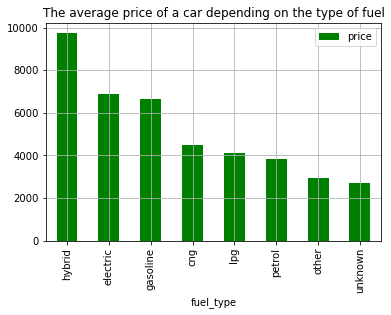

In [21]:
df_proc.groupby('fuel_type').mean().sort_values(by='price', ascending=False)['price'].plot(
    kind='bar', title='The average price of a car depending on the type of fuel', color='green', grid=True, legend=True);

Видно, что тип топлива автомобиля влияет на его цену. Так, автомобили с гибридным типом топлива имеют среднюю стоимость практически 10 000 евро, когда следующий за ним тип, электрический, уже около 7000. Наиболее дешёвыми оказываются автомобили с бензинным топливом. Также часть автомобилей имеет неопредённый вид топлива, поэтому делать выводы по последним двум столбцам нельзя.

Обратимся к другому признаку. На гипотетическом уровне очевидно, что машины, бывшие в ремонте, имеют менее высокую стоимость. Посмотрим, так ли это и какова эта разница:

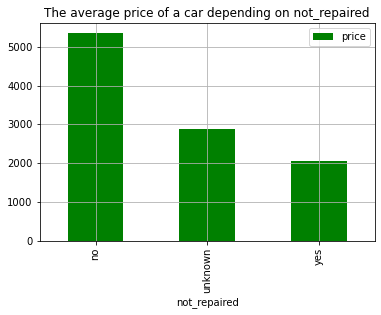

In [22]:
df_proc.groupby('not_repaired').mean().sort_values(by='price', ascending=False)['price'].plot(
    kind='bar', title='The average price of a car depending on not_repaired', color='green', grid=True, legend=True);

Наблюдается разница более, чем в 2 раза. При этом, машины, о ремонте которых ничего не известно, имеют стоимость чуть выше, чем те, которые в ремонте были. Вероятно, достаточно большое количество машин из такого сегмента была в ремонте, но владельцы предпочли этого не указывать - подобное может отпугнуть желаемых покупателей.

Выведем на экран матрицу корреляций для количественных признаков. С категориальными и их влиянием на целевой признак продолжим работу после перекодирования:

In [23]:
df_proc.corr()

,price,registration_year,power,kilometer,registration_month,postal_code
price,1.000000,0.372484,0.155549,-0.354096,0.093871,0.077180
registration_year,0.372484,1.000000,0.032723,-0.189147,0.037137,0.025720
power,0.155549,0.032723,1.000000,0.020542,0.036268,0.021510
kilometer,-0.354096,-0.189147,0.020542,1.000000,-0.000880,-0.013426
registration_month,0.093871,0.037137,0.036268,-0.000880,1.000000,0.011913
postal_code,0.077180,0.025720,0.021510,-0.013426,0.011913,1.000000


Видно, что на цену также активно влияет год регистрации автомобиля, при этом корреляция положительная. Количество пройденных километров, напротив, влияет отрицательно: чем больше машина прошла км, тем меньше она стоит. Это объясняется достаточно логично, ведь чем дольше предмет находится в активном пользовании, тем больше вероятность наличия у него каких-либо поломок. Подробнее остановимся на годе регистрации. Добавим в датафрейм дополнительный столбец, который будет соответствовать году регистрации автомобиля с округлением "вниз" до ближайшего числа, которое делится на 10 без остатка. Выведем график распределения количества машин по этому признаку:

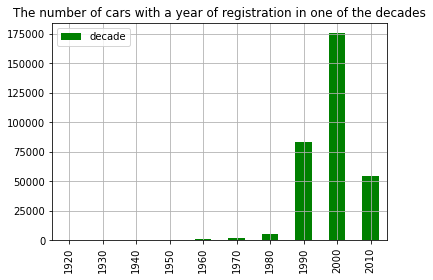

In [24]:
df_proc['decade'] = 10 * (df_proc['registration_year'] // 10)
df_proc['decade'].value_counts().sort_index().plot(
    kind='bar', title='The number of cars with a year of registration in one of the decades', 
    color='green', grid=True, legend=True);

В таблице представлено незначительное количество автомобилей с регистраций до 1990-ого года. Есть вероятность, что в этом сегменте находятся ретро-машины, которые сегодня могут стоить существенно дороже, чем остальные. Посмотрим, какова средняя цена автомобилей до этого года и после:

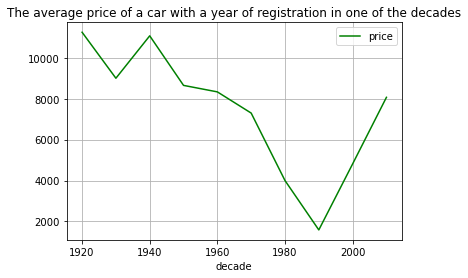

In [25]:
df_proc.pivot_table(index=df_proc['decade'], values='price', aggfunc='mean').plot(
    kind='line', title='The average price of a car with a year of registration in one of the decades', 
    color='green', grid=True, legend=True);

Видно, что автомобили с годом регистрации до 1960-ого явно относятся к классу ретро и стоят дороже, чем новые. 1990-ый год по каким-то причинам вышел чрезмерно низким: средняя цена автомобилей тут не превышает 2000 евро. Вероятно, эти машины пока не вошли в класс ретро, а просто считаются устаревшей техникой, которой мало кто хочет пользоваться. Далее, как и можно было ожидать, наблюдается постепенный рост средней цены.

От исследовательского анализ перейдём к моделям машинного обучения.

## Обучение моделей

### Подготовка к обучению моделей

Обработаем все категориальные признаки методом OHE-кодирования:

In [26]:
df_proc_ohe = pd.get_dummies(df_proc, drop_first=True)

Теперь необходимо собрать численные признаки, чтобы затем отскалировать их. Сначала отдельно выделим такие признаки:

In [27]:
num_features = ['kilometer', 'power']

Напишем функцию, которая будет принимать на вход выборку, а возвращать её уже с отскалированными признаками:

In [28]:
def scaling(data):
    scaler = StandardScaler()
    scaler.fit(data[num_features])
    data[num_features] = scaler.transform(data[num_features])
    return data

Вызовем функцию для нашего датафрейма:

In [29]:
df_proc_ohe = scaling(df_proc_ohe)

Теперь объединим признаки и целевой признак в отдельные переменные:

In [30]:
features = df_proc_ohe.drop('price', axis=1)
target = df_proc_ohe['price']

Перед обучением моделей необходимо разбить выборку на обучающую, валидационную и тестовую в пропорции 3:1:1:

In [31]:
features_train, features_valid, target_train, target_valid = train_test_split(features, target, 
                                                                              test_size=0.2, random_state=RANDOM_STATE, shuffle=False)
features_train, features_test, target_train, target_test = train_test_split(features_train, target_train, 
                                                                              test_size=0.25, random_state=RANDOM_STATE, shuffle=False)

Убедимся, что получили необходимую размерность в выборках:

In [32]:
print(f'Размер обучающей выборки: {len(target_train) / len(df_proc):.2}')
print(f'Размер валидационной выборки: {(len(target_valid) / len(df_proc)):.2}')
print(f'Размер тестовой выборки: {(len(target_test) / len(df_proc)):.2}')

Размер обучающей выборки: 0.6
Размер валидационной выборки: 0.2
Размер тестовой выборки: 0.2


Размерности соблюдены. Далее можем переходить к самому обучению моделей.

### Модели

#### Линейная регрессия

Для сравнения будем считать время выполнения некоторых ячеек кода командой `%%time`. Начнём обучение моделей с простой линейной регрессии. Обучим её:

In [33]:
%%time

model_lr = LinearRegression()
model_lr.fit(features_train, target_train)

Wall time: 2.96 s


LinearRegression()

Отдельной ячейкой посчитаем предсказания линейной регрессии:

In [34]:
%%time

predictions_lr = model_lr.predict(features_test)

Wall time: 61.8 ms


Наконец, найдём метрику качества модели. Для этого рассчитаем `RMSE`:

In [35]:
rmse = mean_squared_error(target_test, predictions_lr, squared=False)
print(f'RMSE линейной регрессии составляет: {rmse:.2f}')

RMSE линейной регрессии составляет: 2832.57


В целом, можно сказать, что линейная регрессия достаточно быстро обучается, предсказывает, однако имеет крайне низкие показатели качества - RMSE 2832. Посмотрим, как себя покажут другие модели.

#### Случайный лес

Попробуем модель случайного леса. Перед обучением модели перекодируем категориальные переменные датасета в порядковое кодирование вместо OHE - это существенно ускорит время работы этой и следующей модели:

In [36]:
encoder = OrdinalEncoder()
encoder.fit(df_proc)

df_proc_ordinal = pd.DataFrame(encoder.transform(df_proc), columns=df_proc.columns)

Отмасштабируем количественные признаки. Для этого воспользуемся уже написанной функцией:

In [37]:
df_proc_ordinal = scaling(df_proc_ordinal)

Объединим признаки по целевому и остальным, а затем разобьём выборки на обучающую, валидационную и тестовую в пропорции 3:1:1. После этого выведем их размеры:

In [38]:
features = df_proc_ordinal.drop('price', axis=1)
target = df_proc_ordinal['price']

features_train_ordinal, features_valid_ordinal, target_train_ordinal, target_valid_ordinal = train_test_split(features, target, 
                                                                              test_size=0.2, random_state=RANDOM_STATE)
features_train_ordinal, features_test_ordinal, target_train_ordinal, target_test_ordinal = train_test_split(features_train_ordinal, 
                                                                    target_train_ordinal, test_size=0.25, random_state=RANDOM_STATE)

print(f'Размер обучающей выборки: {len(target_train) / len(df_proc_ordinal):.2}')
print(f'Размер валидационной выборки: {(len(target_valid) / len(df_proc_ordinal)):.2}')
print(f'Размер тестовой выборки: {(len(target_test) / len(df_proc_ordinal)):.2}')

Размер обучающей выборки: 0.6
Размер валидационной выборки: 0.2
Размер тестовой выборки: 0.2


Обучим модель случайного леса и измерим время обучения:

In [39]:
%%time

model_rfr = RandomForestRegressor()
model_rfr.fit(features_train_ordinal, target_train_ordinal)

Wall time: 57.4 s


RandomForestRegressor()

Время обучения получилось выше, чем у линейной регрессии: 57 секунды против 3 секунд. Посмотрим, сколько времени уйдёт на получение предсказаний:

In [40]:
%%time

predictions_rfr = model_rfr.predict(features_test_ordinal)

Wall time: 1.95 s


В целом, результат получается довольно быстро. Теперь рассчитаем `RMSE` случайного леса:

In [41]:
mse = mean_squared_error(target_test_ordinal, predictions_rfr, squared=False)
print(f'RMSE случайного леса составляет: {mse:.2f}')

RMSE случайного леса составляет: 351.33


RMSE существенно превосходит RMSE линейной регрессии - результат лучше примерно в 8 раз. Однако, такие результаты не так однозначны, ведь время работы модели стало выше. Посмотрим, можно ли улучшить данные результаты путём экспериментирования с гиперпараметрами случайного леса:

In [42]:
the_best_crit = 'squared_error'
the_best_mse = 0

for crit in ('squared_error', 'absolute_error', 'poisson'):
        model = RandomForestRegressor()
        model.fit(features_train_ordinal, target_train_ordinal)
        predictions = model.predict(features_valid_ordinal)
        mse = mean_squared_error(target_valid_ordinal, predictions, squared=False)
        if mse > the_best_mse:
            the_best_crit = crit
            the_best_mse = mse
            
print(f'Наилучший критерий модели: {the_best_crit}')
print(f'Наилучшее RMSE составляет: {the_best_mse}')

Наилучший критерий модели: squared_error
Наилучшее RMSE составляет: 344.7659300721164


Подборка по одному параметру позволила незначительно улучшить метрику `RMSE`. Вместе с тем, такой подбор занимает чрезвычайно много времени, поэтому оставим параметры по умолчанию.

Посмотрим, как модель случайного леса оценила важность признаков в датасете. Эта информация может быть использована, например, с целью дальнейшего сокращения количества признаков, чтобы уменьшить скорость работы моделей, которая важна заказчику.

In [43]:
pd.DataFrame(model_rfr.feature_importances_.reshape(-1, 1), columns=['Importance of the factor'],
            index=features.columns).sort_values(by='Importance of the factor', ascending=False)

,Importance of the factor
registration_year,0.468488
power,0.254026
kilometer,0.069037
postal_code,0.040272
brand,0.037186
vehicle_type,0.032703
model,0.029903
not_repaired,0.022016
registration_month,0.021100
fuel_type,0.010721


Случайный лес наиболее важными факторами выделил год регистрации автомобиля и его мощность. Наименее - тип топлива и тип коробки передач. 

#### Градиентный бустинг

Соберём данные для градиентного бустинга в отдельные датасеты:

In [44]:
lgb_train = lgb.Dataset(features_train_ordinal, target_train_ordinal)
lgb_eval = lgb.Dataset(features_test_ordinal, target_test_ordinal, reference=lgb_train)

Настроим некоторые гиперпараметры модели:

In [45]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
        }

Обучим модель градиентного бустинга и посмотрим, сколько времени это займёт:

In [46]:
%%time

gbm = lgb.train(params, lgb_train, num_boost_round=20, valid_sets=lgb_eval,
callbacks=[lgb.early_stopping(stopping_rounds=5)])

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 936
[LightGBM] [Info] Number of data points in the train set: 192768, number of used features: 12
[LightGBM] [Info] Start training from score 1318.764401
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[20]	valid_0's l1: 444.795	valid_0's l2: 308964
Wall time: 216 ms


Модель обучалась чуть более 13 секунд. В целом, это очень хороший результат, однако всё зависит от метрики качества. Получим предсказания модели и посмотрим, сколько времени это занимает:

In [47]:
%%time

predictions_gbm = gbm.predict(features_test_ordinal, num_iteration=gbm.best_iteration)

Wall time: 19.9 ms


Наконец, получим `RMSE` модели:

In [48]:
mse = mean_squared_error(target_test_ordinal, predictions_gbm, squared=False)
print(f'RMSE градиентного бустинга составляет: {mse:.2f}')

RMSE градиентного бустинга составляет: 555.85


Перейдём к финальному этапу рассмотрения моделей в зависимости от пожеланий заказчика.

## Анализ моделей

Cоздадим датафрейм с объединёнными данными по затраченному времени моделей, а также их метриками `RMSE`:

In [51]:
final_data = pd.DataFrame({'Модель': ['Линейная регрессия', 'Случайный лес', 'Градиентный бустинг'],
                         'Время обучения в сек': [2.96, 57.4, 0.216],
                         'Время предсказания в сек': [0.164, 1.95, 0.2],
                         'RMSE': [2832, 344.76, 555.85]})

Выведем полученную таблицу на экран:

In [52]:
final_data

,Модель,Время обучения в сек,Время предсказания в сек,RMSE
0,Линейная регрессия,2.960,0.164,2832.00
1,Случайный лес,57.400,1.950,344.76
2,Градиентный бустинг,0.216,0.200,555.85


Анализируя эту таблицу, видим, что по времени обучения наиболее качественной оказалась модель градиентного бустинга - она обучается всего 0.216 секунд. Помимо этого, метрика `RMSE` этой модели также оказалась достаточно неплохой. Возможно, внесение дополнительного количества гиперпараметров в модель градиентного бустинга могло бы увеличить метрику, однако тогда время могло бы стать существенно больше.

### Вывод

Линейная регрессия, несмотря на своё время обучения, не рекомендована для использования заказчиком, так как метрика качества тут оказалась наихудшей. Случайный лес, в целом, обучается дольше, но метрика качества выходит лучше. Градиентный бустинг занял наименьшее время обучения, но `RMSE` получился 555 против 344 у случайного леса. 

Из этого можно прийти к выводу, если заказчику хочется получить наибольшую скорость и хорошее качество - стоит применять градиентный бустинг. Если же хочется получить наибольшее качество и чуть менее высокую скорость - случайный лес.

## Общий вывод

По предварительным данным заказчик поставил задачу: определить наилучшую модель для определения рыночной стоимости автомобиля по его характеристикам, при этом модели должны были быть сравнены по различным параметрам. Все данные прошли процедуру предварительной обработки данных, тем самым, можно сказать, что исследование не могло быть искажено какими-либо пробелами в данных. 

Для анализа было выбрано 3 модели от наиболее простой к наиболее сложной: линейная регрессия, случайный лес, градиентный бустинг. По окончании работы и получения финальной метрики все модели были сравнены между собой. В итоге получилось, что модель с наилучшей метрикой, но не лучшим временем обучения является случайный лес (`RMSE` - 344, время обучения - 57.4). Градиентный бустинг занял 0.216 секунд для обучения, однако `RMSE` - 555. Если заказчику нужна быстрота, но чуть менее лучшее качество - можно смело применять градиентный бустинг. Если же выбор падает на метрику - тогда случайный лес.